In [1]:
%matplotlib inline
import numpy
import matplotlib
import matplotlib.pyplot as plt
import os
import sys

In [2]:
import seaborn as sns
sns.set_style('white')
sns.set_palette('colorblind')

In [3]:
from imp import reload
import read_annotations
reload(read_annotations);

In [4]:
ANNOTATIONS_DIR = '/home/milagro/am/third_party/brat-v1.3_Crunchy_Frog/data/'
ANNOTATORS = {
    'mili': {'dirname': 'judgements-mili'},
    'laura': {'dirname': 'judgements-laura'},
    # 'serena': {'dirname': 'judgements-serena'},
    'cristian': {'dirname': 'judgements-cristian'}
}

### Find files to compare

Find pairs of files annotated for more than one annotator.

In [5]:
document_pairs, all_files = read_annotations.get_annotated_documents(ANNOTATIONS_DIR, ANNOTATORS)
all_files

{'cristian': Case: ALKASI v. TURKEY - Ann: C,
 'laura': Case: ALKASI v. TURKEY - Ann: L}

In [6]:
STYLES = {'claim': 'red', 'premise': 'green', 'major-claim': 'blue'}

In [7]:
print(list(all_files.values())[0].sample_labeled_text(35, STYLES))

{Relying on Article 6 of the Convention , }the applicant complains that {the labour court ’ s dismissal of her claim for compensation against her former employer amounted to a violation of her right to be presumed innocent , }in that {the labour court found that she had broken her employer ’ s trust by committing the offence of incitement . }

The applicant argues that {the labour court ’ s complete disregard of her acquittal in relation to the charge of incitement is incompatible with the requirements of Article 6 § 2 of the Convention . }

She further claims that {the Bakırköy Labour Court based its decision on self-incriminating statements which she had given to the police in the absence of her lawyer . }




# Inter annotator agreement

In [8]:
import show_metrics
reload(show_metrics);

## Sentence level comparison

We compare the agreement on classifying argumentative vs non argumentative sentences

Krippendorff Alpha: 0.8409913988229968
Fleiss Kappa: -0.006231003039513794
Kohen-'s Kappa Ann: L - Ann: C: 0.8405698778833107
Observed Agreement: 92.91%


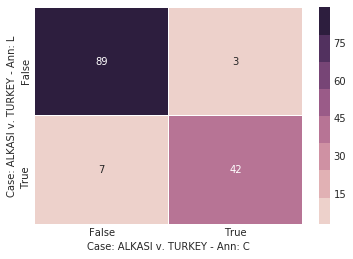

In [9]:
def get_argumentative_sentences(document):
    return [sentence.has_label for sentence in document.sentences]

show_metrics.show_krippendorff_alpha([get_argumentative_sentences(doc)
                                      for doc in all_files.values()])
show_metrics.show_fleiss_kappa([get_argumentative_sentences(doc)
                                      for doc in all_files.values()])
for doc1, doc2 in document_pairs:
    labels1 = get_argumentative_sentences(doc1)
    labels2 = get_argumentative_sentences(doc2)
    show_metrics.show_kappa(labels1, labels2, doc1.identifier, doc2.identifier)
    show_metrics.show_confusion_matrix(labels1, labels2, doc1.identifier, doc2.identifier)

----
## Token level comparison

### Identification

Kappa agreement using labels `Args` vs `Non-Arg`.

Fleiss Kappa: 0.000763477572637144


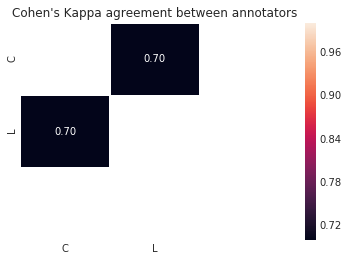

In [15]:
def get_argumentative_words(labels):
    return ['Arg' if x != 'O' else 'O' for x in labels]

# show_metrics.show_krippendorff_alpha(
#     [get_argumentative_words(doc.get_word_label_list()[1]) for doc in all_files.values()])
show_metrics.show_fleiss_kappa(
    [get_argumentative_words(doc.get_word_label_list()[1]) for doc in all_files.values()])
show_metrics.show_general_agreement(document_pairs, process_function=get_argumentative_words,
                                    annotators=len(ANNOTATORS))

Kohen-'s Kappa Ann: L - Ann: C: 0.6984728131598241
Observed Agreement: 84.92%


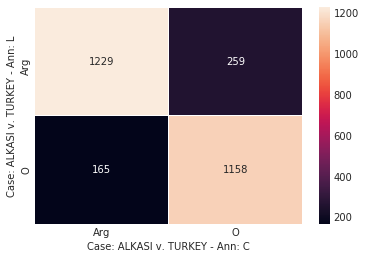

In [35]:
for doc1, doc2 in document_pairs:
    labels1, labels2 = read_annotations.get_labels(doc1, doc2)
    labels1 = get_argumentative_words(labels1)
    labels2 = get_argumentative_words(labels2)
    show_metrics.show_kappa(labels1, labels2, doc1.identifier, doc2.identifier)
    show_metrics.show_confusion_matrix(labels1, labels2, doc1.identifier, doc2.identifier)

----
### Classification

Kappa agreement using labels `claim`, `major-claim` and `premise`

Fleiss Kappa: 0.0003062189489378058


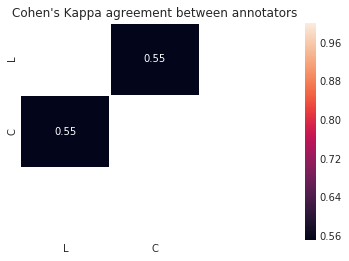

In [38]:
# show_metrics.show_krippendorff_alpha(
#     [get_argumentative_words(doc.get_word_label_list()[1]) for doc in all_files.values()],
#     label_names=['Arg', 'O'])
show_metrics.show_fleiss_kappa(
    [doc.get_word_label_list() for doc in all_files.values()])
show_metrics.show_general_agreement(document_pairs)

Fleiss Kappa: 0.0004164871732768387
Kohen-'s Kappa Ann: L - Ann: M: 0.6204455731646765
Observed Agreement: 76.36%


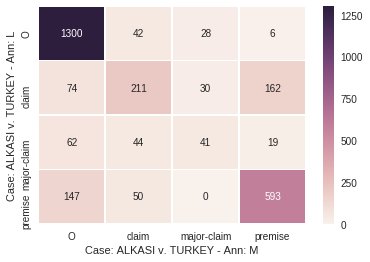

Kohen-'s Kappa Ann: L - Ann: C: 0.5621032080482211
Observed Agreement: 72.41%


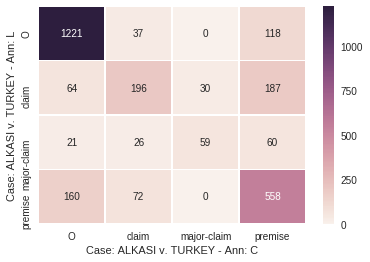

Kohen-'s Kappa Ann: M - Ann: C: 0.6154574663127527
Observed Agreement: 76.97%


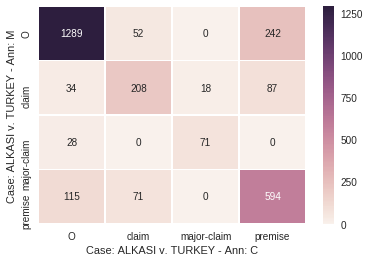

In [23]:
for doc1, doc2 in document_pairs:
    labels1, labels2 = read_annotations.get_labels(doc1, doc2)
    show_metrics.show_kappa(labels1, labels2, doc1.identifier, doc2.identifier)
    show_metrics.show_confusion_matrix(labels1, labels2, doc1.identifier, doc2.identifier)

Kappa agreement using only labels `claim` and `premise`

Fleiss Kappa: 0.004118755050439442


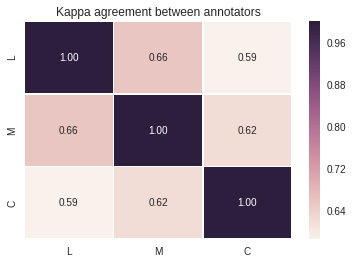

In [72]:
def get_simplified_labels(labels):
    return [x if x != 'major-claim' else 'claim' for x in labels]

# show_metrics.show_krippendorff_alpha(
#     [get_simplified_labels(doc.get_word_label_list()[1]) for doc in all_files.values()],
#     label_names=['Arg', 'O'])
show_metrics.show_fleiss_kappa(
    [get_simplified_labels(doc.get_word_label_list()[1]) for doc in all_files.values()])
show_metrics.show_general_agreement(document_pairs, process_function=get_simplified_labels)

Fleiss Kappa: 0.004118755050439442
Kohen-'s Kappa Ann: L - Ann: M: 0.6553943977235748
Observed Agreement: 79.00%


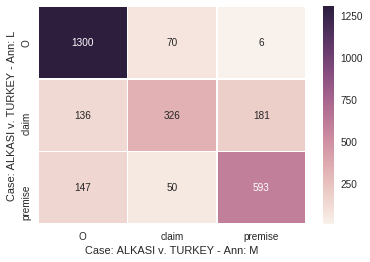

Kohen-'s Kappa Ann: L - Ann: C: 0.5856264881150832
Observed Agreement: 74.40%


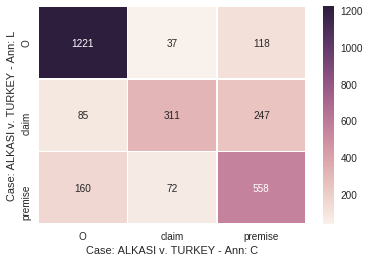

Kohen-'s Kappa Ann: M - Ann: C: 0.6210520739433395
Observed Agreement: 77.61%


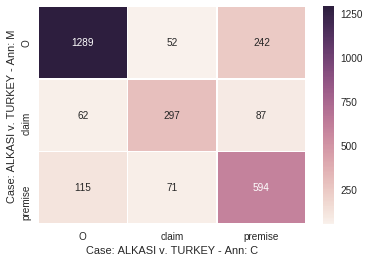

In [24]:
for doc1, doc2 in document_pairs:
    labels1, labels2 = read_annotations.get_labels(doc1, doc2)
    labels1 = get_simplified_labels(labels1)
    labels2 = get_simplified_labels(labels2)
    show_metrics.show_kappa(labels1, labels2, doc1.identifier, doc2.identifier)
    show_metrics.show_confusion_matrix(labels1, labels2, doc1.identifier, doc2.identifier)

## Qualitative error analysis

In [10]:
def sample_sentences(doc1, doc2, label1, label2, tolerance=0):
    """Samples sentences where label1 was confused with label2 in
    doc1 and doc2 respectively.
    """
    total_errors = 0
    for sentence1, sentence2 in zip(doc1.sentences, doc2.sentences):
        indices1 = [i for i, x in enumerate(sentence1.labels) if x == label1]
        if len(indices1) == 0:
            continue
        indices2 = [i for i, x in enumerate(sentence2.labels) if x == label2]
        if len(indices2) == 0 or len(set(indices1).intersection(indices2)) < tolerance:
            continue
        total_errors += len(set(indices1).intersection(indices2))
        # Print both sentences
        print(sentence1.pretty_print(styles=STYLES))
        print(sentence2.pretty_print(styles=STYLES))
        print('---')
    print('TOTAL ERRORS:', total_errors)

Examples labeled as `premise` in one document and as `O` in the other

In [11]:
document_pairs

[(Case: ALKASI v. TURKEY - Ann: L, Case: ALKASI v. TURKEY - Ann: C)]

In [12]:
sample_sentences(document_pairs[0][0], document_pairs[0][1], 'O', 'premise', tolerance=1)

{The second aspect of the protection afforded by Article 6 § 2 requires that a person must be treated in a manner that is consistent with his or her innocence after the conclusion of criminal proceedings which have terminated in an acquittal or discontinuation }( {ibid. , § 103 ) }. 
The second aspect of the protection afforded by Article 6 § 2 requires that {a person must be treated in a manner that is consistent with his or her innocence after the conclusion of criminal proceedings which have terminated in an acquittal or discontinuation ( ibid. , § 103 ) . }
---
( {see Allen , cited above , § 104 ) }. 
{( see Allen , cited above , § 104 ) . }
---
In the application of the above principles to the present case , the Court will have regard to the applicability of Article 6 § 2 to the impugned decision of the Bakırköy Labour Court by determining whether a link existed between the criminal proceedings and the subsequent labour proceedings . 
In the application of the above principles to 